In [3]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [2]:
tf.__version__

'2.10.0'

In [11]:
shutil.copy("Data/cAb-rep/cAb-Rep_heavy.nt.fasta", "Data/cAb-rep/cAb-Rep_heavy.nt.txt")

'Data/cAb-rep/cAb-Rep_heavy.nt.txt'

In [12]:
with open("Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    head = [next(myfile) for x in range(2000)]
print(head[1])

AACCTACTGGAGTCTGGGGGAGGCTTAGTCAAGCCAGGAGGGTCCCTGAGACTGTCTTGTGAAGGCTCAGGATTCCTGTTCAGTCACTATTACATGAGTTGGATACGCCAGGGTCCCGAGAAGAGACTGGAGTTGGTTGCATACATTAGCTCCAATAGTACCGCCTTTTATTACGCAGACTCTGTGAAGGGCCGCTTCACCGTTTCCAAGGACGACGCCAAGAAGTCTGTGTTTCTCCAAATGACTTCCGTGTCAAGCGACGACACGGCCACCTATTACTGTGCGACGGGGGATTGGAGTCGTACCAATAACTTCGACACCTGGGGCCAGGGAACCCAGGTCATCGTCTCC



In [13]:
healthy_sequences = []
for i in head:
    if i.find("cdr3_aa_seq=") == -1:
        continue
    inner_str = i.split('cdr3_aa_seq=')[-1].split('size=')[0]
    healthy_sequences.append(inner_str)

In [14]:
df = pd.read_csv("Data/CoV-AbDab_031022.csv")
df = df[["CDRH3"]]
df = df.head(1000)
df

,CDRH3
0,ARGQLGPWVGVDY
1,ARQGWLRGNFDY
2,ASQLWLRGAFDI
3,ARKGWLRGAFDI
4,ARKGWLRGAFDI
...,...
995,ARDLGPYGMDV
996,ARDLGAYGMDV
997,ARLPYGMDV
998,ARLPYGMDV


In [15]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))
# print(covid_sequences)

28
28


In [16]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [17]:
covid_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in covid_sequences:
    count = 0
    b = np.zeros((28, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    covid_onehot.append(b)

# print(covid_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((28, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(covid_onehot))

# set infected 1, healthy 0

1000


In [18]:
healthy_lables = [0] * 1000
covid_lables = [1] * 1000

In [19]:
X = np.concatenate((healthy_onehot, covid_onehot))
y = np.concatenate((healthy_lables, covid_lables))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 20)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-11-20 14:11:54.089025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 14:11:54.089171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val))

Epoch 1/20


2022-11-20 14:11:54.379088: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 14:11:54.686142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 2s 15ms/step - loss: 0.6883 - accuracy: 0.5025 - val_loss: 0.6692 - val_accuracy: 0.5833
Epoch 2/20
 7/51 [===>..........................] - ETA: 0s - loss: 0.6508 - accuracy: 0.5848

2022-11-20 14:11:56.112201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 0s 10ms/step - loss: 0.6118 - accuracy: 0.6932 - val_loss: 0.6183 - val_accuracy: 0.7278
Epoch 3/20
51/51 [==============================] - 1s 10ms/step - loss: 0.5115 - accuracy: 0.8198 - val_loss: 0.6486 - val_accuracy: 0.6611
Epoch 4/20
51/51 [==============================] - 0s 10ms/step - loss: 0.4438 - accuracy: 0.8691 - val_loss: 0.6693 - val_accuracy: 0.6889
Epoch 5/20
51/51 [==============================] - 0s 9ms/step - loss: 0.3999 - accuracy: 0.9025 - val_loss: 0.6957 - val_accuracy: 0.6889
Epoch 6/20
51/51 [==============================] - 0s 9ms/step - loss: 0.3604 - accuracy: 0.9241 - val_loss: 0.7507 - val_accuracy: 0.6833
Epoch 7/20
51/51 [==============================] - 1s 10ms/step - loss: 0.3390 - accuracy: 0.9315 - val_loss: 0.8156 - val_accuracy: 0.6722
Epoch 8/20
51/51 [==============================] - 0s 9ms/step - loss: 0.3264 - accuracy: 0.9352 - val_loss: 0.7635 - val_accuracy: 0.7056
Epoch 9/20
51/51 [=========

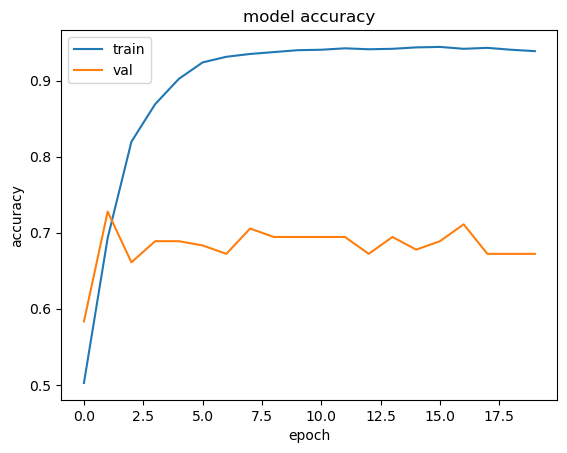

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 20ms/step - loss: 0.7132 - accuracy: 0.7750


[0.713164210319519, 0.7749999761581421]